# Predicting Ames Housing Prices using various Linear Regression Models

### by Jamie McElhiney

## Problem Statement

How can we accurately predict housing prices? We want to pose as a real estate consultant and my clients are people who want to sell their houses. Its important to give an accurate quote on house price tag since people want their house to be sold within a reasonable time frame and at a good price so they get their money's worth. Also, a lot of people make a living off of flipping houses, so being able to maximize profit in these cases is important. We are going to build a baseline model trained on the data set found on kaggle here:[Ames Housing Data](https://www.kaggle.com/c/dsi-us-10-project-2-regression-challenge/data). We will then use a RidgeCV fit to produce a more accurate model and compare and contrast their metrics. We have to think about we handle outliers that (we think) will strongly affect our model? How bout features that are very similar in nature and are related? What metrics are we going to look at to determine accuracy. What are the best practices for making sure all of our linear assumptions are met? We are going to try and address all these questions and issues and build the best possible linear model. 

## Executive Summary

We are using the dataset linked above to train an advanced regression model to come to a conclusion about how to price our clients houses. We want to identify features that are have high correlation coefficients and will be persent in our model so we can advise our clients appropriately. For example our kitchen quality feature is highly correlated with Sale Price, so if a home has a below average kitchen, a renovation may be needed.   
    We looked at some outliers with simple scatter plots and dug into the dataset to see if there was any indication of why their price was not in line with the data. We found nothing to indicate a reason, so they were dropped from the sit.  
    We also thought about our geographic region in this case, Ames, Iowa, and determine why certain features may have high correlations and did some background research into why that may be. We used a heat map of highest correlated features with sale price to see which features stuck out. We found most of our Basement features, such as total basement square footage and basement exposure had high correlation. This is specific to Iowa because Iowa is in a tornado-heavy area and residents usually seek shelter in their basements while they wait for the tornado to pass. This is why Basement features hold more weight in our model and why we include them when developing a baseline model and moving forward.   
    We ran into issues with null values and we wanted to fill them appropriately. Using the [Data Dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), I looked at what the equivalent of a null values was for each feature. For example a null value in a continuous variable would be filled with 0. A null value in a feature where the original corresponding feature did not exist, would be filled with NA or None depending on the feature and again, referring to the data dictionary linked above. 
    Some features were engineered, specifically a feature that combined full bathrooms and half bathrooms. We also made an age sold feature, the age of the house when it was sold, and a year remodeled before feature, a feature saying how long ago from the sale year was the house remodeled. If features were added or subtracted to create a new feature, they were not included in the model. 
    Logarithmic transformations were applied to larger continuous variables to normalize their distribution so they could work with our model. These decision were based on our EDA histogram subplots and variables that have heavy skew were transformed. Dummy columns were created from values that could not be quantified so we could accout for neighborhoods, different types, and miscellaneous features. Any feature that COULD be quantified, their values were mapped to integers usually ranking from 1-7 or however many types/values were available. 
    Root mean squared error was used to evaluate our model's accuracy. the root mean squared error is determined by equation. $$\text{RMSE}=\sqrt{\text{MSE}}=\sqrt{\sum_{i=1}^{n}{(\hat{y}_i-y_i)}^2}$$
We started with a basic OLS model and determined performance with the RMSE value of 34,593.29 dollars. We then moved to a Lasso regressio model, evaluated its performance with similar standards and proved it to be a much more accurate model to our clients with the provided RMSE of 19,044.27 dollars. 


In [1]:
##Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV,ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from statsmodels.formula.api import ols
from numpy import ma
pd.options.display.max_columns = None

In [2]:
##read in csv with pd.read_csv
train2=pd.read_csv('./datasets/train.csv')
test2=pd.read_csv('./datasets/test.csv')

The data notebook mentions outliers that we may want to consider removing. So lets take a look

In [3]:
train2.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000


## EDA

### Missing values

In [4]:
train2.isnull().sum().sort_values(ascending=False).head(30)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
Overall Cond         0
Exterior 2nd         0
Exterior 1st         0
Roof Matl            0
dtype: int64

In [5]:
train2.isnull().mean().sort_values(ascending=False).head(15)

Pool QC           0.995612
Misc Feature      0.968308
Alley             0.931741
Fence             0.804973
Fireplace Qu      0.487567
Lot Frontage      0.160897
Garage Finish     0.055583
Garage Cond       0.055583
Garage Qual       0.055583
Garage Yr Blt     0.055583
Garage Type       0.055095
Bsmt Exposure     0.028279
BsmtFin Type 2    0.027304
BsmtFin Type 1    0.026816
Bsmt Cond         0.026816
dtype: float64

### Outlier detection
A major part of our exploratory data analysis involves detecting outliers that may severely alter the accuracy of our model, or may have be something we just want to keep our eyes on. 

Text(0, 0.5, 'Price ($)')

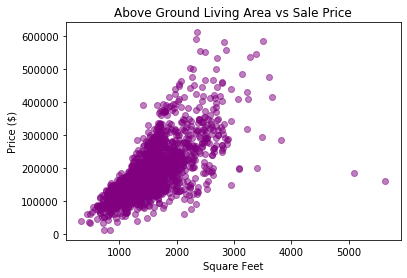

In [6]:
plt.scatter(train2['Gr Liv Area'],train2['SalePrice'],color='purple',alpha=0.5)
plt.xlabel('Square Feet')
plt.title('Above Ground Living Area vs Sale Price')
plt.ylabel('Price ($)')

Scatter Plot: We want to identify the outliers discussed in the notebook based on GrLivArea and Sale Price. 

In [7]:
train2[train2['Gr Liv Area']>4000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
960,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2.0,1418.0,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,160000
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


Lets look through features to see if anything sets these apart that would be a reason for them having such low sale price (looking at Sale Type specifically). So no there is no indication, looks like they are real outliers, so we will drop these observations. 

Text(0, 0.5, 'Price ($)')

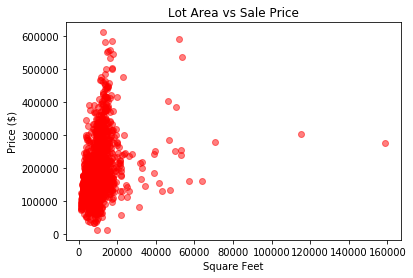

In [8]:
plt.scatter(train2['Lot Area'],train2['SalePrice'],color='red',alpha=0.5)
plt.xlabel('Square Feet')
plt.title('Lot Area vs Sale Price')
plt.ylabel('Price ($)')

Same case for Lot Area. Lets identify these outliers and decide. 

In [9]:
train2[train2['Lot Area']>100000]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
471,2116,906426060,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,Gd,TA,CBlock,Gd,TA,Gd,Rec,697.0,Unf,0.0,747.0,1444.0,GasA,Gd,Y,SBrkr,1444,700,0,2144,0.0,1.0,2,0,4,1,Gd,7,Typ,2,TA,Attchd,1958.0,Fin,2.0,389.0,TA,TA,Y,0,98,0,0,0,0,NaN,NaN,Shed,500,6,2007,WD,277000
694,2072,905301050,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,1219.0,Unf,0.0,424.0,1643.0,GasA,TA,Y,SBrkr,1824,0,0,1824,1.0,0.0,2,0,2,1,Gd,5,Typ,2,TA,Attchd,1971.0,Unf,2.0,739.0,TA,TA,Y,380,48,0,0,0,0,NaN,NaN,NaN,0,6,2007,WD,302000


Again, looks like they're real outliers. Lets drop all of these.

In [10]:
train2.drop([960,1885],inplace=True)
train2.drop([471,694],inplace=True)

#### Checking time-related variables

Garage from future?


In [11]:
train2["Garage Yr Blt"].describe()


count    1933.000000
mean     1978.692188
std        25.445003
min      1895.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2207.000000
Name: Garage Yr Blt, dtype: float64

In [12]:
train2[train2['Garage Yr Blt']>2019]

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
1699,2261,916384070,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,267300


In [13]:
#Lets set to 2007 as it is probably just a typo 
#we look into the data to see yr built is 2006 and year add/mod is 2007.
train2.loc[1699,'Garage Yr Blt']=2007

In [14]:
train2["Year Remod/Add"].describe()


count    2047.000000
mean     1984.147044
std        21.033822
min      1950.000000
25%      1964.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: Year Remod/Add, dtype: float64

In [15]:
#Year Built after garage as built?
train2[(train2['Year Built']>train2['Garage Yr Blt'])][['Year Built','Garage Yr Blt']]

,Year Built,Garage Yr Blt
72,1959,1954.0
77,1927,1920.0
336,1935,1920.0
493,1935,1926.0
533,1941,1940.0
902,2006,2005.0
1076,1923,1922.0
1686,1950,1949.0
1716,1930,1925.0
1907,1963,1962.0


We have a few points where the house was built after the garage was built. Nothing too outlandish here, as the garage may have been a living unit before and then converted to a garage. 

In [16]:
train2.shape

(2047, 81)

In [17]:
train2[(train2['Pool Area']>0)&(train2['Pool QC'].isnull())][['Pool Area','Pool QC']]

,Pool Area,Pool QC


In [18]:
train2[(train2['Fireplaces']>0)&(train2['Fireplace Qu'].isnull())][['Fireplaces','Fireplace Qu']]

,Fireplaces,Fireplace Qu


### Correlation Heatmap

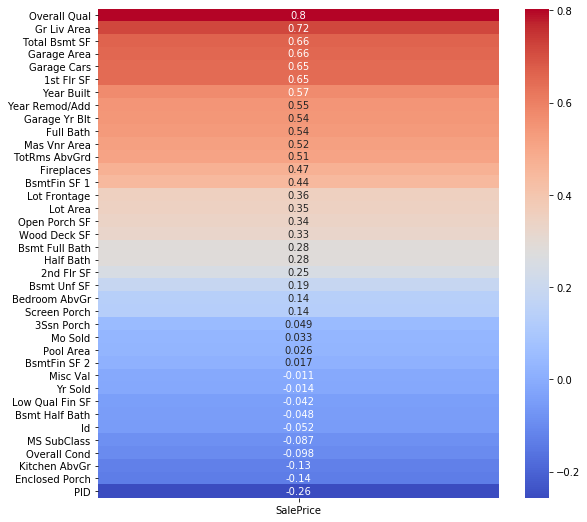

In [19]:
plt.figure(figsize=(9,9))
sns.heatmap(train2.corr()[['SalePrice']].drop('SalePrice').sort_values('SalePrice', ascending = False), annot = True, cmap = "coolwarm")


Heatmap: Grabs top 20 correlation coefficients of our features in comparison with Sale Price. We can get a sense of what variables we may want to include in our model. We want high coefficients (close to 1 or -1) and may want to drop variables with coefficients near 0.

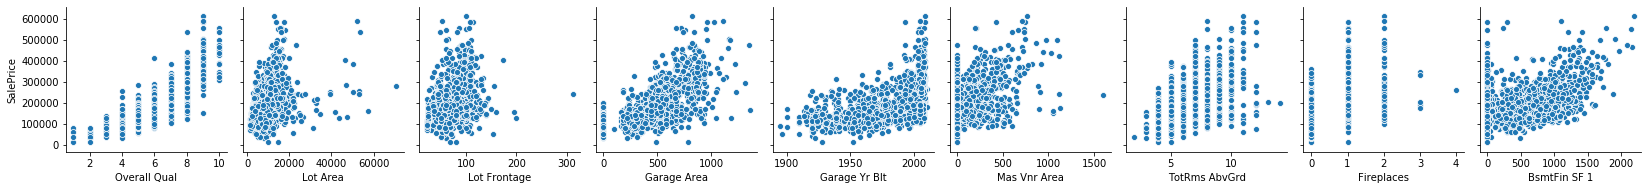

In [20]:
sns.pairplot(train2,y_vars=['SalePrice'],x_vars=['Overall Qual', 'Lot Area','Lot Frontage','Garage Area','Garage Yr Blt',
                                                'Mas Vnr Area','TotRms AbvGrd','Fireplaces','BsmtFin SF 1'])

Pairplots to get more detailed visualizations of how each indp. variable is correlated with our response variable.

Text(0.5, 1.0, 'Sale Price Distribution by Neighborhood')

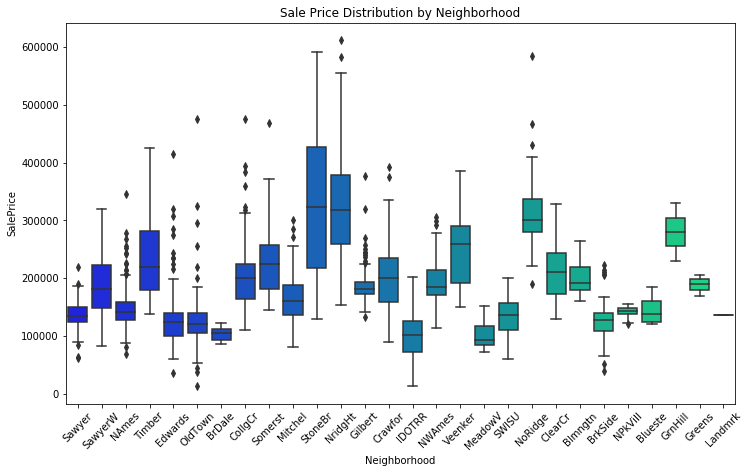

In [21]:
plt.figure(figsize=(12, 7))
s=sns.boxplot(x='Neighborhood', y='SalePrice', data=train2, palette='winter')
s.set_xticklabels(train2.Neighborhood.unique(), rotation = 45)
s.set_title('Sale Price Distribution by Neighborhood')

#g.set_xticks(range(len(df))) # <--- set the ticks first
#g.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])

Quick Box plot graph of sale price per neighborhood. We can more easily visualize the IQR of the range of sale prices per each neighborhood.

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


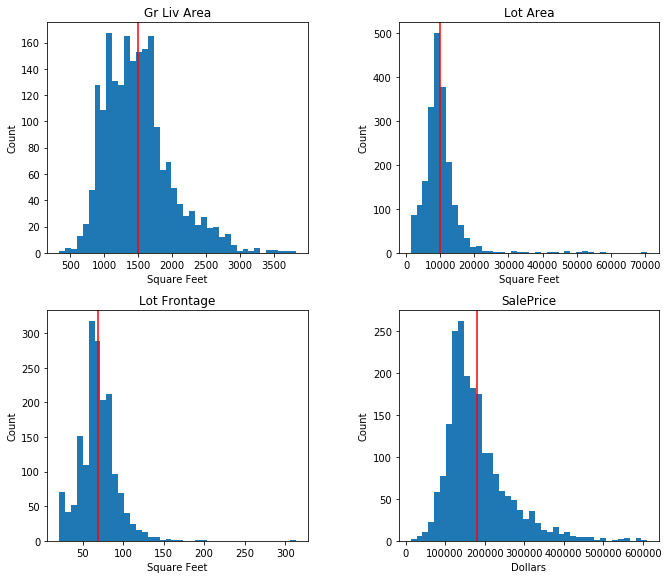

In [22]:
def subplot_histograms(dataframe, list_of_columns, list_of_titles,list_of_xlabels):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],bins=40) # feel free to add more settings
        # Set titles, labels, etc here for each subplot
        ax[i].set_xlabel(list_of_xlabels[i])
        ax[i].set_title(list_of_titles[i])
        ax[i].set_ylabel('Count')
        ax[i].axvline(x=np.mean(dataframe[column]),color='red')

        #ax.set_title('How fast do you want to go today?')
        ax[i].figure.set_size_inches(10, 10)
    plt.subplots_adjust(top=.8, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
subplot_histograms(train2,['Gr Liv Area','Lot Area','Lot Frontage','SalePrice'],
                   ['Gr Liv Area','Lot Area','Lot Frontage','SalePrice'],
                  ['Square Feet','Square Feet','Square Feet','Dollars'])

Histograms: Lets look at the distributions of some of our variables, dependent and independent. We may want to make some log transformations on these variables to better deal with heavy outliers. Specifically we would want to transform SalePrice to adhere to the assumption that our continuous target is normally distributed. 

We also notice that a handful of entries for Lot Frontage have an entry of 0, which doesnt make sense (Lot doesnt exist..?) So we will handle this with imputation.

In [23]:
train1=train2

In [24]:
test6=test2._get_numeric_data()
train6=train2._get_numeric_data()

## Log Transformation

In [25]:
##SalePrice is not normally distributed so lets try the LogSalePrice as the predicted variable

In [26]:
train2['SalePriceLog']=np.log(train2['SalePrice'])

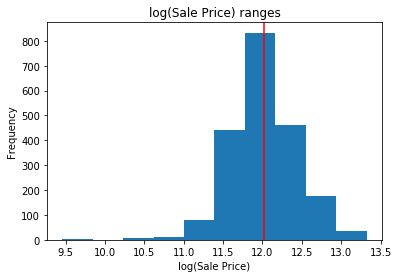

In [27]:
plt.figure(figsize=(6,4))
plt.title("log(Sale Price) ranges")
plt.xlabel("log(Sale Price)")
plt.ylabel("Frequency")
plt.hist(train2["SalePriceLog"])
plt.axvline(x=np.mean(train2['SalePriceLog']),color='red')

Much better!

## Regression Imputation of Lot Frontage

Below we are going to set up a simpler regression model to impute the 0-valued Lot Frontage observations. Our problem is that this will consequently break one of our linear assumptions that our independent variables are not correlated with each other (multicollinearity). Creating a model to impute an independent variable based on other indep. variables will a portion of our data to be collinear. We can prevent this by adding random error. 

In [28]:
train4=train2[(train2['Lot Area'].notnull())&(train2['Neighborhood'].notnull())][['Lot Frontage','Lot Area','Neighborhood']]
train4=pd.get_dummies(train4,columns=['Neighborhood'],drop_first=True)

In [29]:
to_model=train4[(train4['Lot Frontage'].notnull())]

In [30]:
to_predict=train4[(train4['Lot Frontage'].isnull())].drop('Lot Frontage',axis=1)

In [31]:
to_model_X=to_model.drop('Lot Frontage',axis=1)

In [32]:
to_model_Y=to_model['Lot Frontage']

In [33]:
model = sm.OLS(to_model_Y,to_model_X)
results = model.fit()

In [34]:
x=results.predict(to_predict)

In [35]:
for i,j in zip(x.index,x):
    
    train2.ix[i,'Lot Frontage']= j

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


(array([130., 810., 957., 120.,  24.,   3.,   2.,   0.,   0.,   1.]),
 array([  6.1240776 ,  36.81166984,  67.49926208,  98.18685432,
        128.87444656, 159.5620388 , 190.24963104, 220.93722328,
        251.62481552, 282.31240776, 313.        ]),
 <a list of 10 Patch objects>)

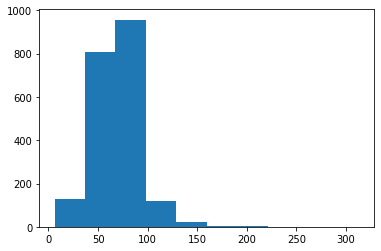

In [36]:

plt.hist(train2['Lot Frontage'])

## Feature Engineering (Simple)

In [37]:
#consolidate bathrooms into one feature, counting half baths as 0.5
train2['FullHalfBath']=train2['Full Bath']+train2['Half Bath']*0.5

In [38]:
test2['FullHalfBath']=test2['Full Bath']+test2['Half Bath']*0.5

In [39]:
#create age sold from yr sold - year built
train2['AgeSold']=train2['Yr Sold']-train2['Year Built']
#create ordinal variable of yr sold - minimum yr sold. 
train2['YrSldOrd']=train2['Yr Sold']-train2['Yr Sold'].min()
#Years remodeled before the house was built.
train2['YrsRemodeledBefore']=train2['Yr Sold']-train2['Year Remod/Add']
#Years remodeled AFTER the house was built
train2['YrsRemodeledAfter']=train2['Year Remod/Add']-train2['Year Built']

In [40]:
test2['AgeSold']=test2['Yr Sold']-test2['Year Built']
test2['YrSldOrd']=test2['Yr Sold']-test2['Yr Sold'].min()
test2['YrsRemodeledBefore']=test2['Yr Sold']-test2['Year Remod/Add']
test2['YrsRemodeledAfter']=test2['Year Remod/Add']-test2['Year Built']

In [41]:
#Fireplace * fireplace quality interaction term
# train2['FireplaceQual']=train2['Fireplaces']*train2['Fireplace Qu']
# test2['FireplaceQual']=test2['Fireplaces']*test2['Fireplace Qu']

## Filling Nulls

In [42]:
#If there is a garage, but no Garage Yr Blt, fill with the year the house was built. 
train2['Garage Yr Blt']=train2['Garage Yr Blt'] .fillna(value=train2['Year Built']) 
train2[['Mas Vnr Type','Garage Type']]=train2[['Mas Vnr Type','Garage Type']].fillna(value='None')
train2['Mas Vnr Area']=train2['Mas Vnr Area'].fillna(value=0)
train2[['Alley','Pool QC','Misc Feature','Fence','Garage Cond','Garage Qual','Fireplace Qu','Garage Finish']]=train2[['Alley','Pool QC','Misc Feature','Fence','Garage Cond','Garage Qual','Fireplace Qu','Garage Finish']].fillna(value='NA')
train2[['Total Bsmt SF','Bsmt Unf SF','BsmtFin SF 2','Garage Area','Garage Cars','Bsmt Full Bath','BsmtFin SF 1',
       'BsmtFin Type 1','BsmtFin Type 2','Lot Frontage','Bsmt Half Bath']]=train2[['Total Bsmt SF','Bsmt Unf SF',
        'BsmtFin SF 2','Garage Area','Garage Cars','Bsmt Full Bath','BsmtFin SF 1','BsmtFin Type 1',
        'BsmtFin Type 2','Lot Frontage','Bsmt Half Bath']].fillna(value=0)
train2[['Bsmt Qual','Bsmt Cond','Bsmt Exposure']]=train2[['Bsmt Qual','Bsmt Cond','Bsmt Exposure']].fillna(value='NA')
##Filling Null Values Appropriately

In [43]:
#If there is a garage, but no Garage Yr Blt, fill with the year the house was built. 
test2['Garage Yr Blt']=test2['Garage Yr Blt'] .fillna(value=test2['Year Built']) 
test2[['Mas Vnr Type','Garage Type']]=test2[['Mas Vnr Type','Garage Type']].fillna(value='None')
test2['Mas Vnr Area']=test2['Mas Vnr Area'].fillna(value=0)

test2[['Alley','Pool QC','Misc Feature','Fence','Garage Cond','Garage Qual','Fireplace Qu',
       'Garage Finish']]=test2[['Alley','Pool QC','Misc Feature','Fence','Garage Cond',
                                'Garage Qual','Fireplace Qu','Garage Finish']].fillna(value='NA')

test2[['Total Bsmt SF','Bsmt Unf SF','BsmtFin SF 2','Garage Area','Garage Cars','Bsmt Full Bath','BsmtFin SF 1',
       'BsmtFin Type 1','BsmtFin Type 2','Lot Frontage','Bsmt Half Bath']]=test2[['Total Bsmt SF','Bsmt Unf SF',
        'BsmtFin SF 2','Garage Area','Garage Cars','Bsmt Full Bath','BsmtFin SF 1','BsmtFin Type 1',
        'BsmtFin Type 2','Lot Frontage','Bsmt Half Bath']].fillna(value=0)

test2[['Bsmt Qual','Bsmt Cond','Bsmt Exposure']]=test2[['Bsmt Qual','Bsmt Cond','Bsmt Exposure']].fillna(value='NA')

In [44]:
train2.shape

(2047, 87)

In [45]:
test2.shape

(878, 85)

## Dummies

In [46]:
dummies=['MS SubClass','Neighborhood','MS Zoning','Condition 1',
         'Exterior 1st','Foundation','Paved Drive','Condition 2','Bldg Type','Roof Style','Roof Matl',
         'Exterior 2nd','Central Air','Electrical','Sale Type','Fence','Misc Feature',
'Heating','Yr Sold','Lot Shape'
        ]
##Creating dummies of features we cannot quantify
test5=test2
train5=train2
train5=train5.drop(['SalePrice'],axis=1)
traintest=pd.concat((train5,test5))
##we are going to kind of branch off here to do the full dummy retrieval. 
## we will concatonate the test and train data vertically, get dummies of the full set, and split on the correct index

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [47]:
print(train5.shape)
print(test5.shape)
print(traintest.shape)##will have many print statements to confirm size

(2047, 86)
(878, 85)
(2925, 86)


In [48]:
traintest=pd.get_dummies(traintest,columns=dummies,drop_first=True)##getting full dummies

In [49]:
traintest.shape

(2925, 216)

In [50]:
test2=traintest.iloc[2047:,:]##splitting vetically at 2047

In [51]:
train2=traintest.iloc[:2047,:]

In [52]:
#test2=pd.concat((test2,testdummies),axis=1)

In [53]:
#train2=pd.concat((train2,traindummies),axis=1)

In [54]:
print(train2.shape)##lets see if were good
print(test2.shape)

(2047, 216)
(878, 216)


In [55]:
train2=pd.concat((train2,train1['SalePrice']),axis=1)##lets get sale price back in there

In [56]:
train2.shape

(2047, 217)

## Ordinal Mapping

In [57]:
##We are going to attempt to quantify ordinal features to numbers where we think it is possible to rank . 
title_mapping2={'Bnk':1,'Low':2,'HLS':3,'Lvl':4}
train2['LandContourOrd'] = train2['Land Contour'].map(title_mapping2)
title_mapping3={'Sev':1,'Mod':2,'Gtl':3}
train2['LandSlopeOrd'] = train2['Land Slope'].map(title_mapping3)
title_mapping4={'1.5Unf':1,'SFoyer':2,'1.5Fin':3,'SLvl':4,'1Story':5,'2.5Unf':6,'2Story':7,'2.5Fin':8}
train2['HouseStyleOrd'] = train2['House Style'].map(title_mapping4)
title_mapping5={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
train2['BaseQualOrd'] = train2['Bsmt Qual'].map(title_mapping5)
train2['BaseCondOrd'] = train2['Bsmt Cond'].map(title_mapping5)
train2['Fireplace Qu'] = train2['Fireplace Qu'].map(title_mapping5)
title_mapping6={'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}
train2['BsmtExpOrd'] = train2['Bsmt Exposure'].map(title_mapping6)
title_mapping6={0:0,'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
train2['BsmtFinOrd1'] = train2['BsmtFin Type 1'].map(title_mapping6)
train2['BsmtFinOrd2'] = train2['BsmtFin Type 2'].map(title_mapping6)
title_mapping7={'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
train2['HeatQcOrd']=train2['Heating QC'].map(title_mapping7)
train2['KitchenQualOrd']=train2['Kitchen Qual'].map(title_mapping7)
title_mapping8={'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
train2['FunctionalOrd']=train2['Functional'].map(title_mapping8)
title_mapping9={'NA':0,'Unf':1,'RFn':2,'Fin':3}
train2['GrgFinishedOrd']=train2['Garage Finish'].map(title_mapping9)
train2['GarageQualOrd']=train2['Garage Qual'].map(title_mapping5)
train2['GarageCondOrd']=train2['Garage Cond'].map(title_mapping5)

In [58]:
print(train2.shape)
print(test2.shape)

(2047, 231)
(878, 216)


In [59]:
title_mapping2={'Bnk':1,'Low':2,'HLS':3,'Lvl':4}
test2['LandContourOrd'] = test2['Land Contour'].map(title_mapping2)
title_mapping3={'Sev':1,'Mod':2,'Gtl':3}
test2['LandSlopeOrd'] = test2['Land Slope'].map(title_mapping3)
title_mapping4={'1.5Unf':1,'SFoyer':2,'1.5Fin':3,'SLvl':4,'1Story':5,'2.5Unf':6,'2Story':7,'2.5Fin':8}
test2['HouseStyleOrd'] = test2['House Style'].map(title_mapping4)
title_mapping5={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
test2['BaseQualOrd'] = test2['Bsmt Qual'].map(title_mapping5)
test2['BaseCondOrd'] = test2['Bsmt Cond'].map(title_mapping5)
test2['Fireplace Qu'] = test2['Fireplace Qu'].map(title_mapping5)
title_mapping6={'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4}
test2['BsmtExpOrd'] = test2['Bsmt Exposure'].map(title_mapping6)
title_mapping6={0:0,'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}
test2['BsmtFinOrd1'] = test2['BsmtFin Type 1'].map(title_mapping6)
test2['BsmtFinOrd2'] = test2['BsmtFin Type 2'].map(title_mapping6)
title_mapping7={'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
test2['HeatQcOrd']=test2['Heating QC'].map(title_mapping7)
test2['KitchenQualOrd']=test2['Kitchen Qual'].map(title_mapping7)
title_mapping8={'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
test2['FunctionalOrd']=test2['Functional'].map(title_mapping8)
title_mapping9={'NA':0,'Unf':1,'RFn':2,'Fin':3}
test2['GrgFinishedOrd']=test2['Garage Finish'].map(title_mapping9)
test2['GarageQualOrd']=test2['Garage Qual'].map(title_mapping5)
test2['GarageCondOrd']=test2['Garage Cond'].map(title_mapping5)



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [60]:
print(train2.shape)
print(test2.shape)

(2047, 231)
(878, 230)


In [61]:
test3=test2._get_numeric_data()##dropping any non numeric options so we can run regression
train3=train2._get_numeric_data()

In [62]:
train3['LotFrontageLog']=ma.filled(np.log(ma.masked_equal(train3['Lot Frontage'], 0)), 0)## 

In [63]:
test3['LotFrontageLog']=ma.filled(np.log(ma.masked_equal(test3['Lot Frontage'], 0)), 0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [64]:
train3['LotArealog']=ma.filled(np.log(ma.masked_equal(train3['Lot Area'], 0)), 0)

In [65]:
test3['LotArealog']=ma.filled(np.log(ma.masked_equal(test3['Lot Area'], 0)), 0)

In [66]:
train3['GrLivLog']=ma.filled(np.log(ma.masked_equal(train3['Gr Liv Area'], 0)), 0)

In [67]:
test3['GrLivLog']=ma.filled(np.log(ma.masked_equal(test3['Gr Liv Area'], 0)), 0)

In [68]:
test2.loc[634,'Electrical']='SBrkr'##Lets set this one missing Electrical value to the most common type, standard. 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## Modeling

### Baseline model

In [69]:
X5=train3.drop(['SalePrice','SalePriceLog'],axis=1)

In [70]:
y5=train3['SalePrice']

In [71]:
X7=train3[['Gr Liv Area','Overall Qual','Total Bsmt SF']]

In [72]:
y7=train3['SalePrice']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X7,
    y7,
 # want a small training data to help cause overfitting
    random_state = 155
)

In [74]:
lr=LinearRegression()

In [75]:
model1=lr.fit(X_train,y_train)

In [76]:
model1.coef_

array([   53.35576379, 25771.01275142,    52.89653692])

In [77]:
model1.intercept_

-111768.91665160735

$$ \hat{\text{SalePrice}} = -111,768.92 + 25,771.01(\text{OverallQual}) + 53.36(\text{GrLivArea}) + 52.9(\text{TotalBasementSF})$$

In [78]:
preds1=model1.predict(X_train)
preds2=model1.predict(X_test)



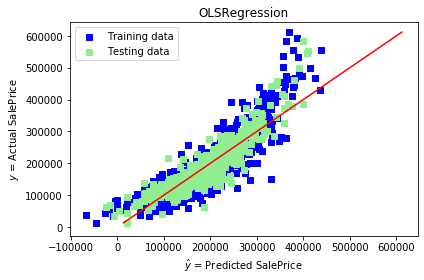

In [79]:
## CREDIT GOES TO ANTHONY LUCCI FOR THIS NICE FUNCTIOn
def plot_predictions(model_name, y_train_pred, y_test_pred, y_train_actual, y_test_actual):
    plt.scatter(y_train_pred, y_train_actual, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test_actual, c = "lightgreen", marker = "s", label = "Testing data")
    plt.title(model_name+"Regression")
    plt.xlabel("$\hat{y}$ = Predicted SalePrice")
    plt.ylabel("$y$ = Actual SalePrice")
    plt.legend(loc = "upper left")
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()
plot_predictions('OLS',preds1,preds2,y_train,y_test)


In [80]:
#error1=preds2-y_test

$$\text{RMSE}=\sqrt{\text{MSE}}=\sqrt{\sum_{i=1}^{n}{(\hat{y}_i-y_i)}^2}=34,593.29\$$$

In [81]:
(metrics.mean_squared_error(y_test, preds2))**0.5

34593.29338255366

In [82]:
model1.score(X_train,y_train)

0.7920195584848121

We have a RMSE of 34,593.29$ which essentially means our predictions were off by an average of \\$34.6k. 

In [83]:
X1=train3.drop(['SalePrice','SalePriceLog'],axis=1)#+X_scaled

In [84]:
y1=train2['SalePriceLog']

### Ridge Model

In [85]:
start = 2##Lets start from 10^-3 to 1 with 1000 intervals 
end   = 4
steps = 1000
l_alphas = np.logspace(start, end, steps)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(##lets initiate our train test splite
    X1,
    y1,
 # want a small training data to help cause overfitting
    random_state = 155
)

In [104]:
test3.drop('SalePriceLog',inplace=True,axis=1)

In [106]:
sc = StandardScaler()##WE are using a regularization model so we must scale our data with standard scaler. 
scaled_X_train = sc.fit_transform(X_train)
scaled_X_test = sc.transform(X_test)
test3 = sc.transform(test3)

In [107]:
scaled_X_train=pd.DataFrame(scaled_X_train)

In [108]:
test3=pd.DataFrame(test3)

In [109]:
# Cross-validate over our list of Ridge alphas.
ridge_model = RidgeCV(alphas = l_alphas, cv = 5)

# Fit model using best alpha found!
ridge_model.fit(scaled_X_train, y_train)

RidgeCV(alphas=array([  100.        ,   100.46204213,   100.9262191 ,   101.39254076,
         101.86101702,   102.33165783,   102.80447321,   103.27947319,
         103.75666787,   104.2360674 ,   104.71768195,   105.20152176,
         105.68759712,   106.17591835,   106.66649583,   107.15933998,
         107.65446128,   108.15187026,   108.65157747,   109.15359353,
         109.65792913,   110.16459496,   110.67360181,   111.18496048,
         111.69868185,   112.21477682,...
        9161.40245714,  9203.73199662,  9246.25711641,  9288.97872016,
        9331.89771573,  9375.01501515,  9418.33153465,  9461.84819472,
        9505.5659201 ,  9549.48563979,  9593.60828709,  9637.93479962,
        9682.4661193 ,  9727.20319245,  9772.14696973,  9817.29840619,
        9862.65846131,  9908.228099  ,  9954.00828762, 10000.        ]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [110]:
cross_val_score(ridge_model,scaled_X_train,y_train,cv=5).mean()##Good crossvalscore

0.9076678857094838

In [111]:
ridge_model.alpha_##identify our penalty coefficient

249.11300260677885

In [112]:
x=scaled_X_train.values.tolist()

In [113]:
y=y_train.values.tolist()

In [115]:
np.exp(ridge_model.intercept_)

166078.1819571253

In [116]:
best_features = [tup for tup in list(zip(ridge_model.coef_,X1.columns)) if tup[0] != 0]
best_features.sort(reverse=True) #descending order
best_features##lets zip up our features that were not given a 0 Beta value by our penalty 

[(0.055163952373240496, 'Overall Qual'),
 (0.04112249035005748, 'GrLivLog'),
 (0.03455565137002013, 'Gr Liv Area'),
 (0.03291402476484987, 'Overall Cond'),
 (0.029269538008178317, '1st Flr SF'),
 (0.028791006404897193, 'FunctionalOrd'),
 (0.025363050086879384, 'Total Bsmt SF'),
 (0.024280152291185225, 'BsmtFin SF 1'),
 (0.021851439178943544, 'KitchenQualOrd'),
 (0.020389641977089385, 'LotArealog'),
 (0.01800892862795661, 'Exterior 1st_BrkFace'),
 (0.016672634729221293, 'Paved Drive_Y'),
 (0.016442572752297192, 'Neighborhood_NridgHt'),
 (0.016396936938790848, 'TotRms AbvGrd'),
 (0.015894356794705723, 'Screen Porch'),
 (0.015579653520462288, 'Neighborhood_GrnHill'),
 (0.01556762278220279, 'Year Built'),
 (0.014581641934793915, 'Sale Type_New'),
 (0.014000314852790893, 'BaseQualOrd'),
 (0.013809794202771007, 'Year Remod/Add'),
 (0.013444798825759448, 'HeatQcOrd'),
 (0.013354495013901305, 'BsmtExpOrd'),
 (0.012979585555569712, 'Garage Area'),
 (0.01296805782498976, '2nd Flr SF'),
 (0.01283

In [117]:
best_features[0][1]

'Overall Qual'

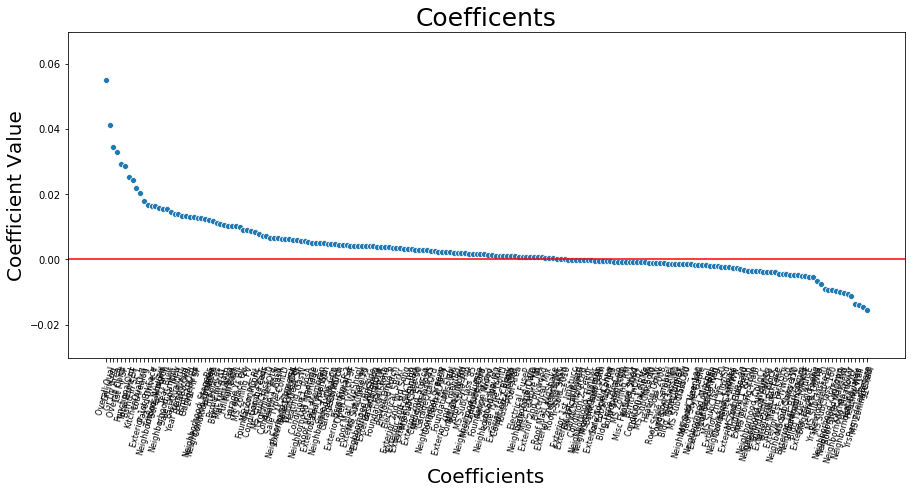

In [118]:
#CREDIT GOES TO GREG RANKEL FOR THIS NICE PLOT
bf = pd.DataFrame(best_features, columns = ['coef','col'])
plt.figure(figsize=(15,6))
plt.title("Coefficents", size = 25)
ax = sns.scatterplot(x='col',y="coef",data=bf,palette="magma")
plt.axhline(0,color = 'red')
plt.xticks(fontsize=8, rotation=90)
ax.set_xlabel('Coefficients', fontsize = 20)
ax.set_ylabel('Coefficient Value', fontsize = 20)

plt.show()

Graph of ridge coefficients with their respective features. We can see features that hold more weight (higher magnituted coefficients) are important features we have identified before in our heatmap.

In [119]:
test3.shape

(878, 209)

In [120]:
X1.shape

(2047, 209)

In [121]:
test3.shape

(878, 209)

In [122]:
preds1=ridge_model.predict(scaled_X_train)##Lets get predictions of our train and test splits so we can evaluate

In [123]:
preds2=ridge_model.predict(scaled_X_test)

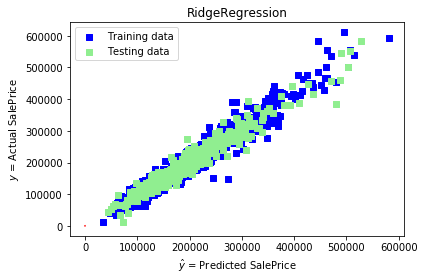

In [124]:
plot_predictions('Ridge',np.exp(preds1),np.exp(preds2),np.exp(y_train),np.exp(y_test))

Scatter Plot: Plot of predicted y values versus actualy y values. If our model is 100% accurate, the plot will be a straight line. So we see it is pretty linear and quite a good model. 

In [125]:
error1=np.exp(preds2)-np.exp(y_test)##residual functions

Text(0, 0.5, 'Error')

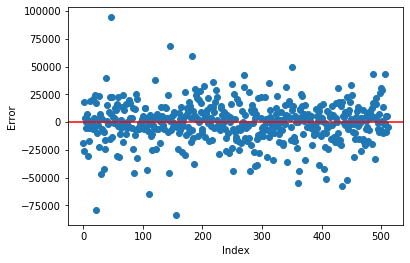

In [126]:
plt.scatter(range(len(error1)),error1)
plt.axhline(0,color='red')
plt.xlabel('Index')
plt.ylabel('Error')

Residual plot: We see a pretty consistent pattern of residuals, confirming homoskedasticity. There is also evident independence of residuals. 

In [127]:
(metrics.mean_squared_error(np.exp(y_test), np.exp(preds2)))**0.5

18223.50918664192

Our RMSE for the ridge model is 19044.27$. This is much lower than our initial baseline model so that great. 

## Conclusion & Recommendations

We made a baseline model with some basic features and fit it to our training data. Our initial root mean squared error for our baseline model was 34,593.29 dollars. So, on average our predictions for our y_test values were off by a value of 34,593.29 dollars. We evaluated our baseline, see where we could improve it, and we decided on a RidgeCV model. This uses a penalty value to to nullify beta coefficients for values that arent as essential to our model. This model was chosen over Ridge, which minimizes instead of nullifys, for simplicitys sake. Having a lower number of features but still managing to have a low RMSE is an ideal end result we want to look for. So we threw in as many features as we could and allowed the penalty to assign 0 to beta coefficients of variables we didnt need. Our highest Beta coefficients were similar to high value features we identified in our heatmaps. GrLivArea, OverallQual, Total Bsmt SF.  We also applied a logarithmic transformation to our dependent variable, SalePrice, to account for the non normal distribution of SalePrice. This allows our model to handle outliers easier. Our new root mean squared error ends up at 18,223.51$, a major improvement from our baseline model. So, we would recommend using a RidgeCV model and overfitting to allow the Ridge to choose our features based on the penalty coefficient we land on. 


In [128]:
preds=ridge_model.predict(test3)

In [129]:
preds_col=pd.Series(preds,name='SalePrice')

In [130]:
id_col=test2['Id']

In [131]:
output=pd.concat([id_col,np.exp(preds_col)],axis=1)


In [132]:
output.head(10)

,Id,SalePrice
0,2658,137774.183694
1,2718,158194.062350
2,2414,223272.285667
3,1989,98564.350207
4,625,171677.013802
5,333,90606.791204
6,1327,112094.448815
7,858,151151.711367
8,95,169919.556269
9,1568,162190.895696


In [133]:
output.to_csv('./output/submission1.csv',index=False)